# Decision Tree classifier

##### *Команда 9:*
* *Басистий Олег*
* *Кравчук Андрій*



![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Основний концепт 
У цьому завданні ми повинні були імплементувати класичний 'механізм' в ML сфері, а саме Decision Tree Classifier. 


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Dataset
Ми вирішили взяти датасет з винами з бібліотеки Sklearn.


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [37]:
# install the required packages

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install graphviz
# !pip install scikit-learn

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# scikit-learn package
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

In [40]:
wine = datasets.load_wine()
dir(wine)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [41]:
wine.data.shape

(178, 13)

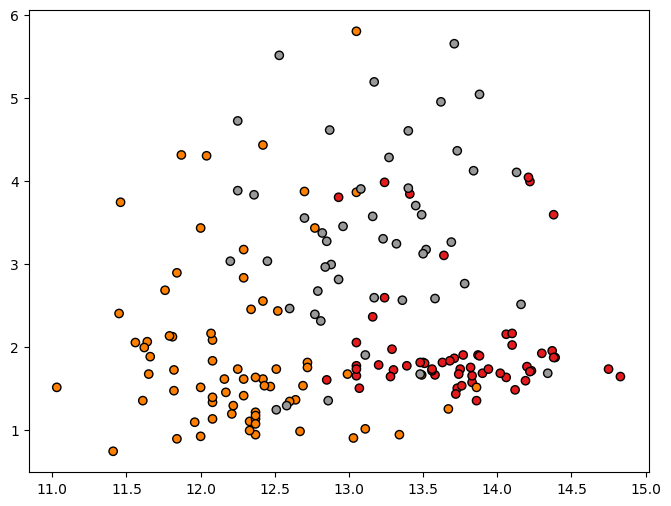

In [42]:
X = wine.data
y = wine.target

plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Результати DTC з готового модуля 

In [43]:
clf = DecisionTreeClassifier()

In [44]:
X, y = wine.data, wine.target
X.shape, y.shape

((178, 13), (178,))

In [45]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)

In [46]:
clf = clf.fit(X, y)

### Візуалізація створеного дерева

In [47]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("wine")

'wine.pdf'

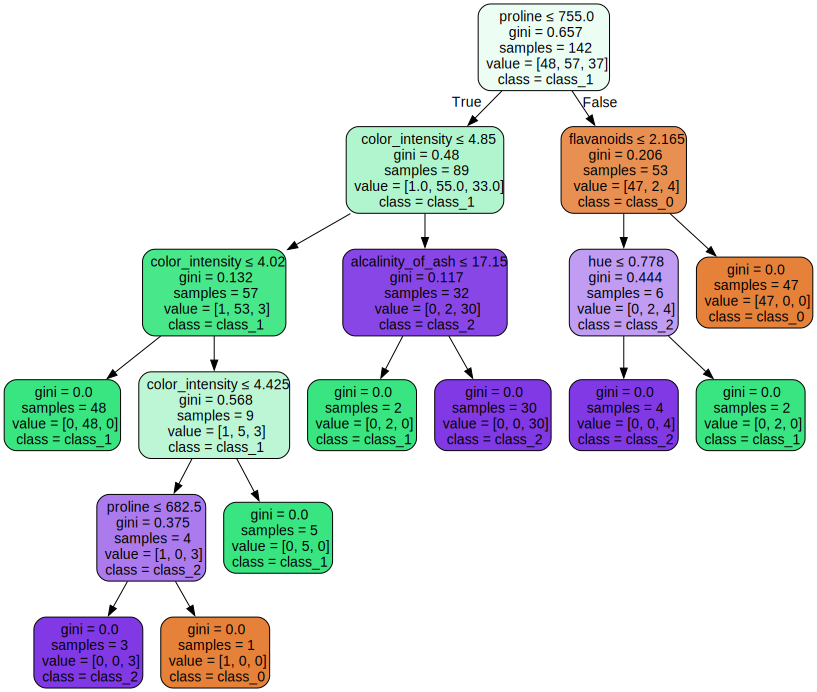

In [48]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=wine.feature_names,  
                     class_names=wine.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [49]:
X_test.shape

(36, 13)

In [50]:
predictions = clf.predict(X_test)

### Підрахунок точності моделі

In [51]:
sum(predictions == y_test) / len(y_test)

0.8333333333333334


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Власна імплементація

### Як працює дерево
В основі нашої програми - одна основа функція, split_data. Її мета - знайти найкращий розподіл класів, за допомогою "чистота" буде найкращою.  Найчистіший розподіл допоможе нам якнайточніше правильно класифікувати вхідні дані.
#####  Джині чистота
В минулому абзаці не раз було згадано слово 'чистота'. ML моделі зазвичай використовують так звану 'cost' функцію, задля обчислення, наскільки певний варіант розподілу є хорошим.  
Дерева рішень використовують концепт чистоти Джіні, задля обчислення чистоти вершини. Чим ближче Джіні до 0, тим більш чистою є вершина.  
Вершина чиста, якщо всі її зразки з одного класу. Якщо ж, кожен зразок буде з різного класу - Джіні буде близитись до 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

Якщо у вершини 5 зразків, 2 з яких з першого класу, ще 2 - з другого, 1 з 3 і ніякі з 4, то 

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

##### Побудова дерева
build_tree - рекурсивно будує дерево, розділяючись на лівих та правих синів, допоки не дійде до максимальної глибини, або ж до кінця дерева.
##### Fit
fit - так звана "загортка" самого дерева. Отримує на вхід дані та розбудовує дерево.
##### Передбачення результатів
predict - перебігає по всіх вершинах та, дійшовши до листка, обчислює 'передбачення' (до якого класу належатиме екземпляр).
evaluate - обчислює точність обрахунків.
 

In [52]:
class Node:
    
    def __init__(self, X, y, gini):
        self.X = X
        self.y = y
        self.gini = gini
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [53]:
class MyDecisionTreeClassifier:
    
    def __init__(self, max_depth):
        self.max_depth = max_depth
    @staticmethod
    def gini(groups):
        '''
        A Gini score gives an idea of how good a split is by how mixed the
        classes are in the two groups created by the split.
        
        A perfect separation results in a Gini score of 0,
        whereas the worst case split that results in 50/50
        classes in each group result in a Gini score of 0.5
        (for a 2 class problem).
        '''
        gr_num = sum(groups)
        return 1-sum((i/ gr_num) ** 2 for i in groups)
    
    def split_data(self, X, y):
        """
        test all the possible splits in O(N*F) where N in number of samples
        and F is number of features
        return index and threshold value
        """
        classes_len=y.size
        parents=[sum(y==class_num) for class_num in range(self.n_classes)]
        max_gini=1-sum((x/classes_len)**2 for x in parents)
        max_i=None
        max_threshold=None
        for i in range(self.n_features):
            thresholds,classes=zip(*sorted(zip(X[:,i],y)))
            num_left=[0 for _ in range(self.n_classes)]
            num_right=parents.copy()
            for j in range(1,classes_len):
                curr_class=classes[j-1]
                num_left[curr_class]+=1
                num_right[curr_class]-=1
                gini_left=self.gini(num_left)
                gini_right=self.gini(num_right)
                curr_gini=(j*gini_left+(self.n_classes-j)*gini_right)/self.n_classes
                if thresholds[j]==thresholds[j - 1]:
                    continue
                if curr_gini<max_gini:
                    max_gini=curr_gini
                    max_i=i
                    max_threshold=(thresholds[j]+thresholds[j-1])/2
        return max_i,max_threshold
    
    def build_tree(self, X, y, depth=0):
        """
        create a root node
        recursively split until max depth is not exeeced
        """
        if depth == self.max_depth:
            return Node(X,y,None)
        i,threshold=self.split_data(X, y)
        if i is None:
            return Node(X,y,None)
        i_left=X[:,i] < threshold
        X_left,y_left=X[i_left],y[i_left]
        X_right,y_right=X[~i_left],y[~i_left]
        node=Node(X,y,self.gini(y))
        node.feature_index=i
        node.threshold=threshold
        node.left=self.build_tree(X_left,y_left,depth+1)
        node.right=self.build_tree(X_right,y_right,depth+1)
        return node

    def fit(self, X, y):
        """
        basically wrapper for build tree / train
        """
        self.n_classes=len(set(y))
        self.n_features=X.shape[1]
        self.tree=self.build_tree(X,y)

    def predict(self, X_test):
        """
        traverse the tree while there is a child
        and return the predicted class for it, 
        note that X_test can be a single sample or a batch
        """
        res=[]
        for x in X_test:
            node=self.tree
            while node.left:
                if x[node.feature_index]<node.threshold:
                    node=node.left
                else:
                    node=node.right
            samples=[sum(node.y==x) for x in range(self.n_classes)]
            res.append(samples.index(max(samples)))
        return res

    def evaluate(self, X_test, y_test):
        """
        return accuracy
        """
        predictions=self.predict(X_test)
        return sum(predictions==y_test)/len(y_test)


Навчання моделі на тестових даних + обрахунок точності

In [54]:
clf_my=MyDecisionTreeClassifier(10)
clf_my.fit(X,y)
clf_my.evaluate(X_test,y_test)

0.9444444444444444

### Conclusion

Протягом виконання цієї лабораторної роботи, нам вдалось імплементувати один з базових алгоритмів в ML, Decision Tree Classifier.  
Основний принцип дискретної математики, який тут використовувався - дерева рішень.  
Саме за концептом дерева рішень, наша модель може майже правильно передбачати аутпут для певних вхідних даних.  
У цілому, ми отримали цікавий експіріенс, розбираючись в тому, як це імплементувати.  
При кожному рерані коду, загальна точність виходить в проміжку (0.85; 0.97). Отже, ми виконали роботу правильно.